In [1]:
import torch
import torchvision.transforms as tvt
from torch.utils.data import DataLoader
from tqdm import tqdm
import shutil
import pandas as pd
import numpy as np
import os
torch.manual_seed(1234)
from evaluate_metrics import compute_eer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

## CNSL Intern

In [3]:
# load Intern

cnsl_intern = pd.read_csv("DATA/CNSL_intern/protocol.txt", sep=" ", header=None)
cnsl_intern.columns = ['utt', 'subset', 'category', 'label']
cnsl_intern.head

<bound method NDFrame.head of                                    utt subset category     label
0         real/20230925_sbsnews5_4.wav   eval     Male  bonafide
1          real/20230914sbsenter_4.wav   eval   Female  bonafide
2                   real/podcast_1.wav   eval     Male  bonafide
3          real/230926_HanJuneTV_6.wav   eval     Male  bonafide
4               real/230722_Deep_9.wav   eval     Male  bonafide
...                                ...    ...      ...       ...
1861        real/230831_MBC_Chef_7.wav   eval   Female  bonafide
1862               real/TED_INCA_9.wav   eval     Male  bonafide
1863        real/elle_songhyegyo_5.wav   eval   Female  bonafide
1864  real/230915_YTN_northkorea_8.wav   eval   Female  bonafide
1865              fake/LOL_Combi_3.wav   eval     Male     spoof

[1866 rows x 4 columns]>

### docs/CNSLintern_fuse_join_conf_2_3_epoch_47.txt

EER: 49.5730%, threshold: -3.4235


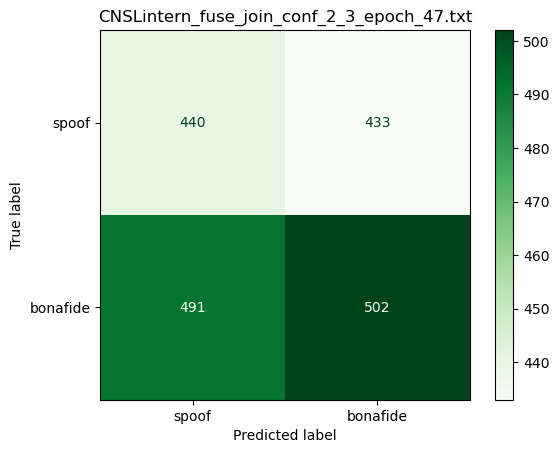

In [6]:
pred_df = pd.read_csv("docs/CNSLintern_fuse_join_conf_2_3_epoch_47.txt", sep=" ", header=None)
pred_df.columns = ["utt","score"]

# pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(cnsl_intern, pred_df, on='utt')

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("CNSLintern_fuse_join_conf_2_3_epoch_47.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()


## ASVspoof 2019

In [3]:
# load eval set
eval_df = pd.read_csv("/datab/Dataset/ASVspoof/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt", sep=" ", header=None)
eval_df.columns = ["sid", "utt","phy", "attack", "label"]
eval_df.head


<bound method NDFrame.head of            sid           utt phy attack     label
0      LA_0039  LA_E_2834763   -    A11     spoof
1      LA_0014  LA_E_8877452   -    A14     spoof
2      LA_0040  LA_E_6828287   -    A16     spoof
3      LA_0022  LA_E_6977360   -    A09     spoof
4      LA_0031  LA_E_5932896   -    A13     spoof
...        ...           ...  ..    ...       ...
71232  LA_0004  LA_E_1665632   -      -  bonafide
71233  LA_0038  LA_E_5085671   -    A09     spoof
71234  LA_0012  LA_E_4926022   -    A16     spoof
71235  LA_0052  LA_E_2894498   -      -  bonafide
71236  LA_0009  LA_E_4689563   -    A19     spoof

[71237 rows x 5 columns]>

### la2019_fuse_freeze_conf_2_epoch_11.txt

EER: 0.2175%, threshold: 1.2634


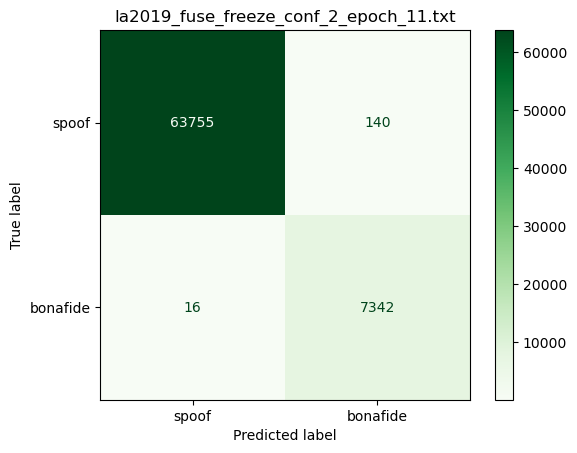

In [10]:
pred_df = pd.read_csv("docs/la2019_fuse_freeze_conf_2_epoch_11.txt", sep=" ", header=None)
pred_df.columns = ["utt","score"]

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(eval_df, pred_df, on='utt')

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("la2019_fuse_freeze_conf_2_epoch_11.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()


6.647062301635742 -6.591047286987305


/tmp/ipykernel_2091144/3262302329.py:30: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  plt.axvline(x=threshold, color='g', linestyle='--', linewidth=1)


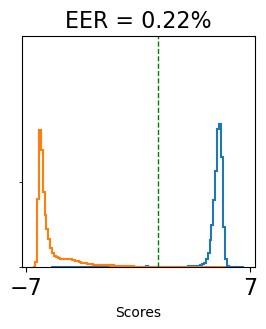

In [11]:
import matplotlib.pyplot as plt
import numpy as np

max_score = max(res_df['score'])
min_score = min(res_df['score'])
print(max_score, min_score)

plt.figure(figsize=(3, 3))
bona = res_df[(res_df['label'] == 'bonafide')]['score']
spoof = res_df[(res_df['label'] == 'spoof')]['score']

# Plotting the distributions as line chart histograms
plt.hist(bona, bins=100, density=True, cumulative=False, histtype='step', linewidth=1.5, label='Bonafide')
plt.hist(spoof, bins=100, density=True, cumulative=False, histtype='step', linewidth=1.5, label='Spoofing')


# Adding labels and title
plt.xlabel('Scores')
# plt.ylabel('score probability density plot')
plt.title('EER = {:.2f}%'.format(eer*100), fontsize=16)
# plt.legend(fontsize=14)
# plt.stick_params(labelsize=16)

# yaxis logit scale
plt.yscale('symlog')

# Adding a legend
# plt.legend(loc='lower right')
# Adding vertical lines
plt.axvline(x=threshold, color='g', linestyle='--', linewidth=1)

# Set the x-axis tick positions and labels
plt.xticks([int(min_score-1),int(max_score+1)], fontsize=16)
plt.yticks([])
plt.ylim(0,5)

# plt.rcParams.update({'font.size': 16})
# Displaying the plot
# plt.savefig("figs/1e-07_3_augall_asvspoof2019_resnet_nll_2l_epoch_49.png", dpi=600)
plt.show()
plt.close()


### la2019_fuse_freeze_conf_1_norm_2_epoch_21.txt

EER: 0.2314%, threshold: 0.9890


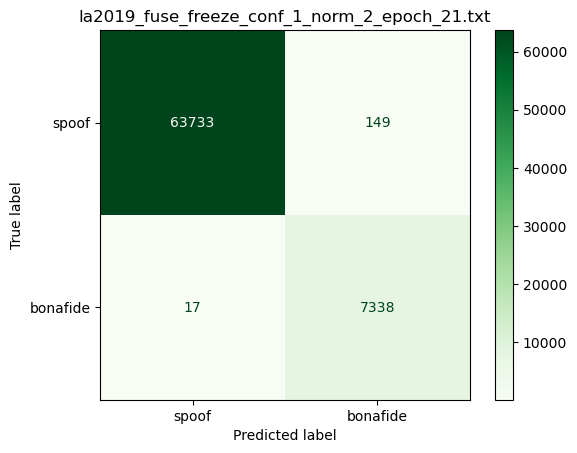

In [6]:
pred_df = pd.read_csv("docs/la2019_fuse_freeze_conf_1_norm_2_epoch_21.txt", sep=" ", header=None)
pred_df.columns = ["utt","score"]

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(eval_df, pred_df, on='utt')

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("la2019_fuse_freeze_conf_1_norm_2_epoch_21.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()


0.9999998807907104 9.348362368655216e-07


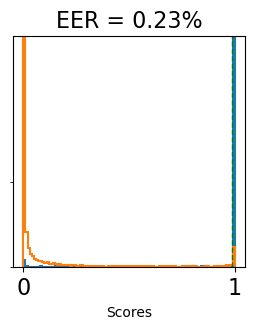

In [7]:
import matplotlib.pyplot as plt
import numpy as np

max_score = max(res_df['score'])
min_score = min(res_df['score'])
print(max_score, min_score)

plt.figure(figsize=(3, 3))
bona = res_df[(res_df['label'] == 'bonafide')]['score']
spoof = res_df[(res_df['label'] == 'spoof')]['score']

# Plotting the distributions as line chart histograms
plt.hist(bona, bins=100, density=True, cumulative=False, histtype='step', linewidth=1.5, label='Bonafide')
plt.hist(spoof, bins=100, density=True, cumulative=False, histtype='step', linewidth=1.5, label='Spoofing')


# Adding labels and title
plt.xlabel('Scores')
# plt.ylabel('score probability density plot')
plt.title('EER = {:.2f}%'.format(eer*100), fontsize=16)
# plt.legend(fontsize=14)
# plt.stick_params(labelsize=16)

# yaxis logit scale
plt.yscale('symlog')

# Adding a legend
# plt.legend(loc='lower right')
# Adding vertical lines
plt.axvline(x=threshold, color='g', linestyle='--', linewidth=1)

# Set the x-axis tick positions and labels
plt.xticks([int(min_score-1),int(max_score+1)], fontsize=16)
plt.yticks([])
plt.ylim(0,5)

# plt.rcParams.update({'font.size': 16})
# Displaying the plot
# plt.savefig("figs/1e-07_3_augall_asvspoof2019_resnet_nll_2l_epoch_49.png", dpi=600)
plt.show()
plt.close()


### 32_0.001_la2019_fuse_freeze_conf_1_norm_epoch_2.txt

EER: 0.2191%, threshold: 1.8370


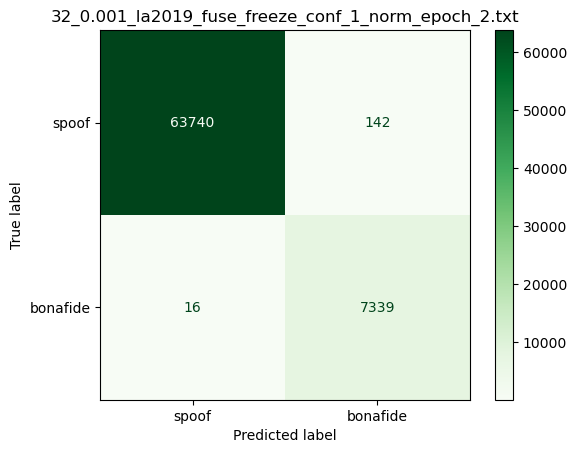

In [8]:
pred_df = pd.read_csv("docs/32_0.001_la2019_fuse_freeze_conf_1_norm_epoch_2.txt", sep=" ", header=None)
pred_df.columns = ["utt","score"]

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(eval_df, pred_df, on='utt')

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("32_0.001_la2019_fuse_freeze_conf_1_norm_epoch_2.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()


7.044524192810059 -6.453349590301514


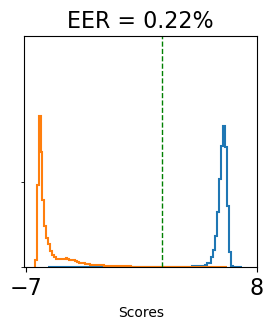

In [9]:
import matplotlib.pyplot as plt
import numpy as np

max_score = max(res_df['score'])
min_score = min(res_df['score'])
print(max_score, min_score)

plt.figure(figsize=(3, 3))
bona = res_df[(res_df['label'] == 'bonafide')]['score']
spoof = res_df[(res_df['label'] == 'spoof')]['score']

# Plotting the distributions as line chart histograms
plt.hist(bona, bins=100, density=True, cumulative=False, histtype='step', linewidth=1.5, label='Bonafide')
plt.hist(spoof, bins=100, density=True, cumulative=False, histtype='step', linewidth=1.5, label='Spoofing')


# Adding labels and title
plt.xlabel('Scores')
# plt.ylabel('score probability density plot')
plt.title('EER = {:.2f}%'.format(eer*100), fontsize=16)
# plt.legend(fontsize=14)
# plt.stick_params(labelsize=16)

# yaxis logit scale
plt.yscale('symlog')

# Adding a legend
# plt.legend(loc='lower right')
# Adding vertical lines
plt.axvline(x=threshold, color='g', linestyle='--', linewidth=1)

# Set the x-axis tick positions and labels
plt.xticks([int(min_score-1),int(max_score+1)], fontsize=16)
plt.yticks([])
plt.ylim(0,5)

# plt.rcParams.update({'font.size': 16})
# Displaying the plot
# plt.savefig("figs/1e-07_3_augall_asvspoof2019_resnet_nll_2l_epoch_49.png", dpi=600)
plt.show()
plt.close()


### AASIST-SSL

EER: 0.2207%, threshold: 1.9948


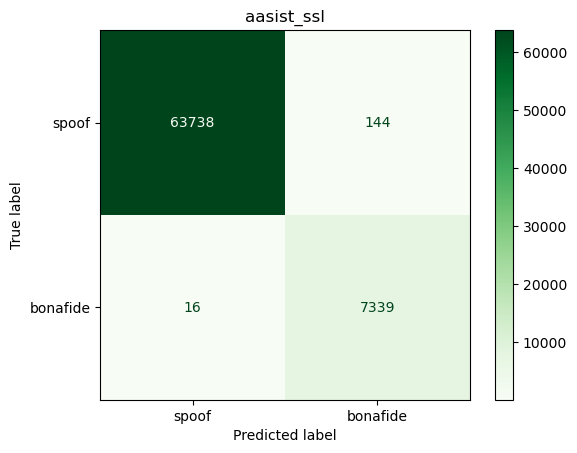

In [37]:
pred_df = pd.read_csv("scores/la2019/aasist_ssl.txt", sep=" ", header=None)
pred_df.columns = ["utt","asdf","score"]

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(eval_df, pred_df, on='utt')

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("aasist_ssl")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()


7.044580459594727 -6.453342437744141


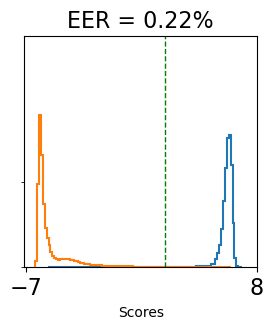

In [38]:
import matplotlib.pyplot as plt
import numpy as np

max_score = max(res_df['score'])
min_score = min(res_df['score'])
print(max_score, min_score)

plt.figure(figsize=(3, 3))
bona = res_df[(res_df['label'] == 'bonafide')]['score']
spoof = res_df[(res_df['label'] == 'spoof')]['score']

# Plotting the distributions as line chart histograms
plt.hist(bona, bins=100, density=True, cumulative=False, histtype='step', linewidth=1.5, label='Bonafide')
plt.hist(spoof, bins=100, density=True, cumulative=False, histtype='step', linewidth=1.5, label='Spoofing')


# Adding labels and title
plt.xlabel('Scores')
# plt.ylabel('score probability density plot')
plt.title('EER = {:.2f}%'.format(eer*100), fontsize=16)
# plt.legend(fontsize=14)
# plt.stick_params(labelsize=16)

# yaxis logit scale
plt.yscale('symlog')

# Adding a legend
# plt.legend(loc='lower right')
# Adding vertical lines
plt.axvline(x=threshold, color='g', linestyle='--', linewidth=1)

# Set the x-axis tick positions and labels
plt.xticks([int(min_score-1),int(max_score+1)], fontsize=16)
plt.yticks([])
plt.ylim(0,5)

# plt.rcParams.update({'font.size': 16})
# Displaying the plot
# plt.savefig("figs/1e-07_3_augall_asvspoof2019_resnet_nll_2l_epoch_49.png", dpi=600)
plt.show()
plt.close()


### Vocosig

EER: 1.9957%, threshold: -0.0009


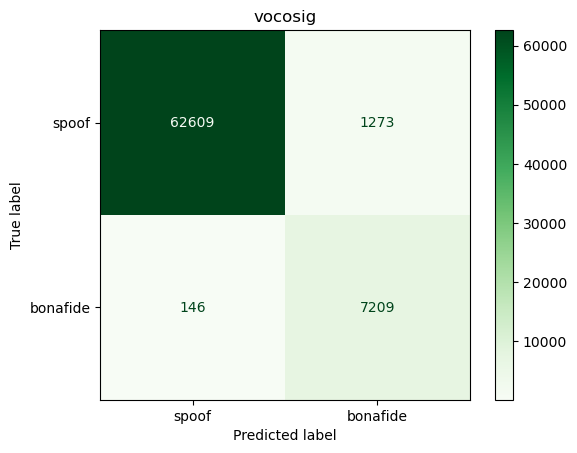

In [35]:
pred_df = pd.read_csv("scores/la2019/vocosig.txt", sep=" ", header=None)
pred_df.columns = ["utt","asdf","score"]

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(eval_df, pred_df, on='utt')

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("vocosig")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()


-0.0007784912013448 -7.515747547149658


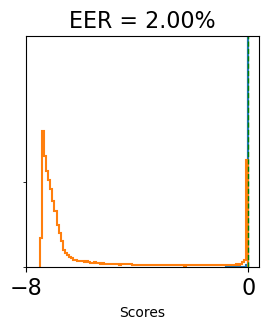

In [36]:
import matplotlib.pyplot as plt
import numpy as np

max_score = max(res_df['score'])
min_score = min(res_df['score'])
print(max_score, min_score)

plt.figure(figsize=(3, 3))
bona = res_df[(res_df['label'] == 'bonafide')]['score']
spoof = res_df[(res_df['label'] == 'spoof')]['score']

# Plotting the distributions as line chart histograms
plt.hist(bona, bins=100, density=True, cumulative=False, histtype='step', linewidth=1.5, label='Bonafide')
plt.hist(spoof, bins=100, density=True, cumulative=False, histtype='step', linewidth=1.5, label='Spoofing')


# Adding labels and title
plt.xlabel('Scores')
# plt.ylabel('score probability density plot')
plt.title('EER = {:.2f}%'.format(eer*100), fontsize=16)
# plt.legend(fontsize=14)
# plt.stick_params(labelsize=16)

# yaxis logit scale
plt.yscale('symlog')

# Adding a legend
# plt.legend(loc='lower right')
# Adding vertical lines
plt.axvline(x=threshold, color='g', linestyle='--', linewidth=1)

# Set the x-axis tick positions and labels
plt.xticks([int(min_score-1),int(max_score+1)], fontsize=16)
plt.yticks([])
plt.ylim(0,5)

# plt.rcParams.update({'font.size': 16})
# Displaying the plot
# plt.savefig("figs/1e-07_3_augall_asvspoof2019_resnet_nll_2l_epoch_49.png", dpi=600)
plt.show()
plt.close()


### 32_0.001_fuse_freeze_conf_1_epoch_59.txt

EER: 0.2207%, threshold: 1.9948


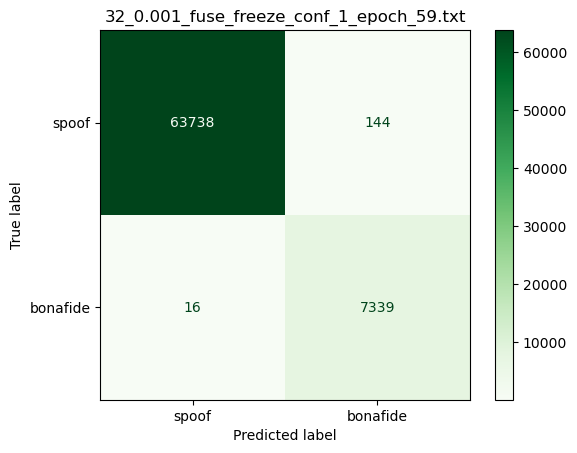

In [32]:
pred_df = pd.read_csv("docs/32_0.001_fuse_freeze_conf_1_epoch_57.txt", sep=" ", header=None)
pred_df.columns = ["utt","score"]

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(eval_df, pred_df, on='utt')

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("32_0.001_fuse_freeze_conf_1_epoch_59.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()


7.044580459594727 -6.453342437744141


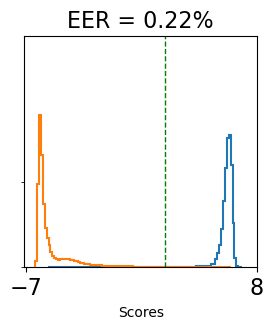

In [33]:
import matplotlib.pyplot as plt
import numpy as np

max_score = max(res_df['score'])
min_score = min(res_df['score'])
print(max_score, min_score)

plt.figure(figsize=(3, 3))
bona = res_df[(res_df['label'] == 'bonafide')]['score']
spoof = res_df[(res_df['label'] == 'spoof')]['score']

# Plotting the distributions as line chart histograms
plt.hist(bona, bins=100, density=True, cumulative=False, histtype='step', linewidth=1.5, label='Bonafide')
plt.hist(spoof, bins=100, density=True, cumulative=False, histtype='step', linewidth=1.5, label='Spoofing')


# Adding labels and title
plt.xlabel('Scores')
# plt.ylabel('score probability density plot')
plt.title('EER = {:.2f}%'.format(eer*100), fontsize=16)
# plt.legend(fontsize=14)
# plt.stick_params(labelsize=16)

# yaxis logit scale
plt.yscale('symlog')

# Adding a legend
# plt.legend(loc='lower right')
# Adding vertical lines
plt.axvline(x=threshold, color='g', linestyle='--', linewidth=1)

# Set the x-axis tick positions and labels
plt.xticks([int(min_score-1),int(max_score+1)], fontsize=16)
plt.yticks([])
plt.ylim(0,5)

# plt.rcParams.update({'font.size': 16})
# Displaying the plot
# plt.savefig("figs/1e-07_3_augall_asvspoof2019_resnet_nll_2l_epoch_49.png", dpi=600)
plt.show()
plt.close()


### la2019_fuse_freeze_conf_1_norm_2_epoch_21.txt

EER: 0.2314%, threshold: 0.9890


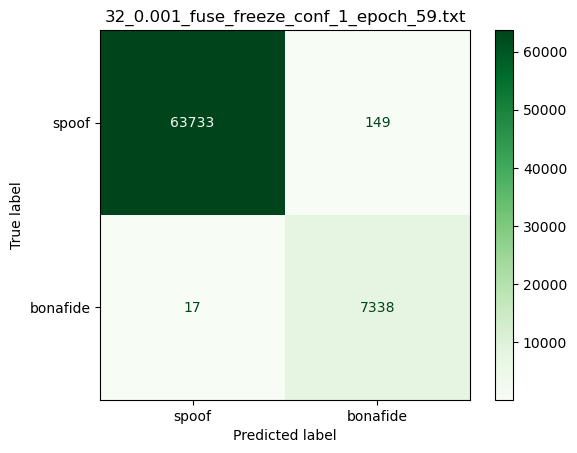

In [58]:
pred_df = pd.read_csv("docs/la2019_fuse_freeze_conf_1_norm_2_epoch_21.txt", sep=" ", header=None)
pred_df.columns = ["utt","score"]

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(eval_df, pred_df, on='utt')

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("32_0.001_fuse_freeze_conf_1_epoch_59.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()


0.9999998807907104 9.348362368655216e-07


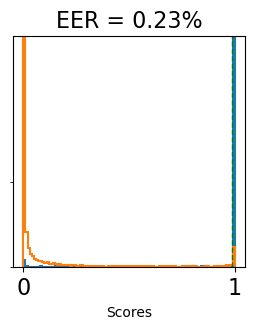

In [59]:
import matplotlib.pyplot as plt
import numpy as np
max_score = max(res_df['score'])
min_score = min(res_df['score'])
print(max_score, min_score)

plt.figure(figsize=(3, 3))
bona = res_df[(res_df['label'] == 'bonafide')]['score']
spoof = res_df[(res_df['label'] == 'spoof')]['score']

# Plotting the distributions as line chart histograms
plt.hist(bona, bins=100, density=True, cumulative=False, histtype='step', linewidth=1.5, label='Bonafide')
plt.hist(spoof, bins=100, density=True, cumulative=False, histtype='step', linewidth=1.5, label='Spoofing')


# Adding labels and title
plt.xlabel('Scores')
# plt.ylabel('score probability density plot')
plt.title('EER = {:.2f}%'.format(eer*100), fontsize=16)
# plt.legend(fontsize=14)
# plt.stick_params(labelsize=16)

# yaxis logit scale
plt.yscale('symlog')

# Adding a legend
# plt.legend(loc='lower right')
# Adding vertical lines
plt.axvline(x=threshold, color='g', linestyle='--', linewidth=1)

# Set the x-axis tick positions and labels
plt.xticks([int(min_score-1),int(max_score+1)], fontsize=16)
plt.yticks([])
plt.ylim(0,5)

# plt.rcParams.update({'font.size': 16})
# Displaying the plot
# plt.savefig("figs/1e-07_3_augall_asvspoof2019_resnet_nll_2l_epoch_49.png", dpi=600)
plt.show()
plt.close()


## DF 2021

In [2]:
# load DF 2021 set
DF_df = pd.read_csv("/datab/Dataset/ASVspoof/LA/ASVspoof2021_keys/DF/CM/trial_metadata.txt", sep=" ", header=None)
DF_df.columns = ["sid", "utt","codec", "src", "attack", "label", "trim", "subset","vocoder","b","c","d","e"]

DF_df.head


<bound method NDFrame.head of             sid           utt     codec       src        attack  label  \
0       LA_0023  DF_E_2000011   nocodec  asvspoof           A14  spoof   
1          TEF2  DF_E_2000013   low_m4a   vcc2020  Task1-team20  spoof   
2          TGF1  DF_E_2000024    mp3m4a   vcc2020  Task2-team12  spoof   
3       LA_0043  DF_E_2000026    mp3m4a  asvspoof           A09  spoof   
4       LA_0021  DF_E_2000027    mp3m4a  asvspoof           A12  spoof   
...         ...           ...       ...       ...           ...    ...   
611824  VCC2TM2  DF_E_4999945    oggm4a   vcc2018       SPO-N16  spoof   
611825  LA_0044  DF_E_4999962    oggm4a  asvspoof           A19  spoof   
611826  LA_0042  DF_E_4999964  high_ogg  asvspoof           A13  spoof   
611827     TEM1  DF_E_4999980   low_m4a   vcc2020  Task1-team07  spoof   
611828     TGF1  DF_E_4999993    mp3m4a   vcc2020  Task2-team33  spoof   

          trim    subset                           vocoder      b       c   d  \


### df2021_fuse_join_conf_2_3_epoch_47.txt

EER: 2.4543%, threshold: -3.5576


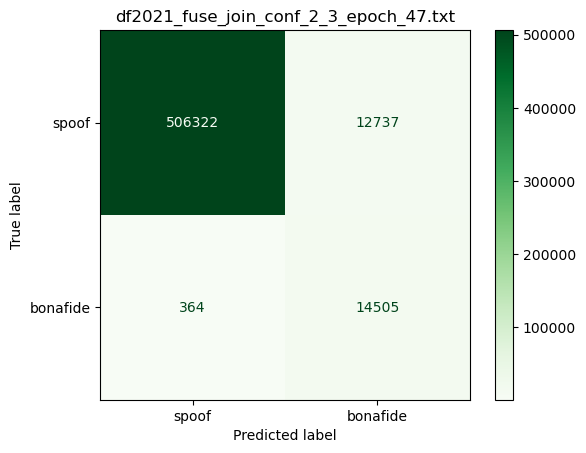

In [3]:

pred_df = pd.read_csv("docs/df2021_fuse_join_conf_2_3_epoch_47.txt", sep=" ", header=None)
pred_df.columns = ["utt", "score"]

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
# merge eval_df and pred_df on utt
res_df = pd.merge(DF_df, pred_df, on='utt')

# filter res_df as subset = ['eval', 'hidden']
res_df = res_df[res_df['subset'] == 'eval']

# filter res_df which has vocoder neural_vocoder_autoregressive
# res_df = res_df[(res_df['vocoder'] == 'neural_vocoder_autoregressive') | (res_df['vocoder'] == 'bonafide')]

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("df2021_fuse_join_conf_2_3_epoch_47.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### df2021_fuse_freeze_conf_3_norm_epoch_14.txt

EER: 2.5691%, threshold: -7.8591


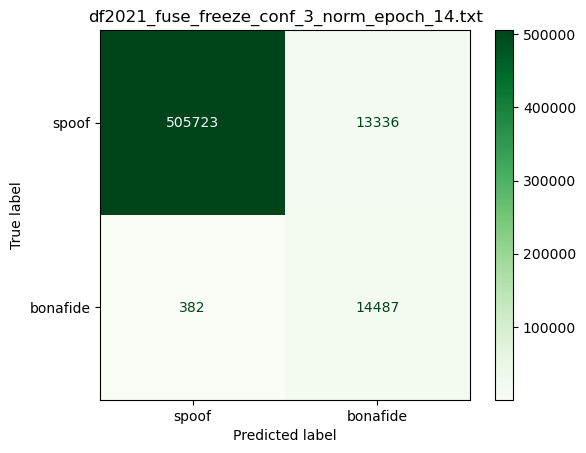

In [17]:

pred_df = pd.read_csv("docs/df2021_fuse_freeze_conf_3_norm_epoch_14.txt", sep=" ", header=None)
pred_df.columns = ["utt", "score"]

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
# merge eval_df and pred_df on utt
res_df = pd.merge(DF_df, pred_df, on='utt')

# filter res_df as subset = ['eval', 'hidden']
res_df = res_df[res_df['subset'] == 'eval']

# filter res_df which has vocoder neural_vocoder_autoregressive
# res_df = res_df[(res_df['vocoder'] == 'neural_vocoder_autoregressive') | (res_df['vocoder'] == 'bonafide')]

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("df2021_fuse_freeze_conf_3_norm_epoch_14.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

-1.460324438085081e-05 -8.62154769897461


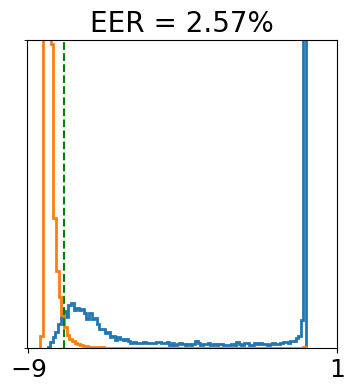

In [18]:
import matplotlib.pyplot as plt
import numpy as np

max_score = max(res_df['score'])
min_score = min(res_df['score'])
print(max_score, min_score)

plt.figure(figsize=(4, 4))
bona = res_df[(res_df['label'] == 'bonafide')]['score']
spoof = res_df[(res_df['label'] == 'spoof')]['score']

# Plotting the distributions as line chart histograms
plt.hist(bona, bins=100, density=True, cumulative=False, histtype='step', linewidth=2, label='Bonafide')
plt.hist(spoof, bins=100, density=True, cumulative=False, histtype='step', linewidth=2, label='Spoofing')


# Adding labels and title
# plt.xlabel('Scores', fontsize=20)
# plt.ylabel('score probability density plot')
plt.title('EER = {:.2f}%'.format(eer*100), fontsize=20)


# yaxis logit scale
plt.yscale('symlog')


# Adding a legend
# plt.legend(loc='lower right')
# Adding vertical lines
plt.axvline(x=threshold, color='g', linestyle='--', linewidth=1.5)

# Set the x-axis tick positions and labels
plt.xticks([int(min_score)-1,int(max_score)+1], fontsize=18)
plt.yticks([])
plt.ylim(0,1)
# save fig
# plt.savefig("figs/aasist-df.pdf", dpi=600)
# Displaying the plot
plt.show()


### df2021_fuse_freeze_conf_2_epoch_11.txt

EER: 2.0183%, threshold: -3.5118


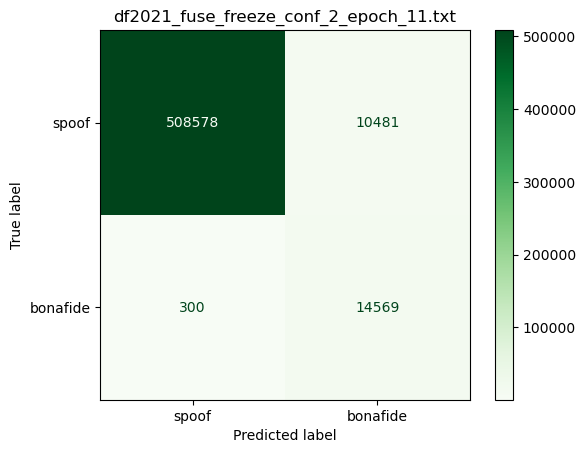

In [11]:

pred_df = pd.read_csv("docs/df2021_fuse_freeze_conf_2_epoch_11.txt", sep=" ", header=None)
pred_df.columns = ["utt", "score"]

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
# merge eval_df and pred_df on utt
res_df = pd.merge(DF_df, pred_df, on='utt')

# filter res_df as subset = ['eval', 'hidden']
res_df = res_df[res_df['subset'] == 'eval']

# filter res_df which has vocoder neural_vocoder_autoregressive
# res_df = res_df[(res_df['vocoder'] == 'neural_vocoder_autoregressive') | (res_df['vocoder'] == 'bonafide')]

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("df2021_fuse_freeze_conf_2_epoch_11.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

4.564865112304688 -5.221974849700928


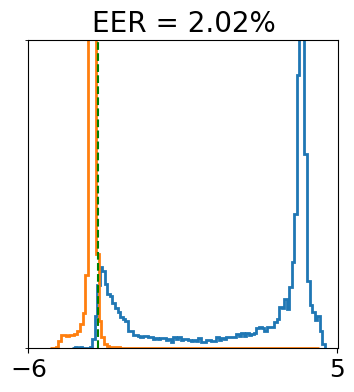

In [12]:
import matplotlib.pyplot as plt
import numpy as np

max_score = max(res_df['score'])
min_score = min(res_df['score'])
print(max_score, min_score)

plt.figure(figsize=(4, 4))
bona = res_df[(res_df['label'] == 'bonafide')]['score']
spoof = res_df[(res_df['label'] == 'spoof')]['score']

# Plotting the distributions as line chart histograms
plt.hist(bona, bins=100, density=True, cumulative=False, histtype='step', linewidth=2, label='Bonafide')
plt.hist(spoof, bins=100, density=True, cumulative=False, histtype='step', linewidth=2, label='Spoofing')


# Adding labels and title
# plt.xlabel('Scores', fontsize=20)
# plt.ylabel('score probability density plot')
plt.title('EER = {:.2f}%'.format(eer*100), fontsize=20)


# yaxis logit scale
plt.yscale('symlog')


# Adding a legend
# plt.legend(loc='lower right')
# Adding vertical lines
plt.axvline(x=threshold, color='g', linestyle='--', linewidth=1.5)

# Set the x-axis tick positions and labels
plt.xticks([int(min_score)-1,int(max_score)+1], fontsize=18)
plt.yticks([])
plt.ylim(0,1)
# save fig
# plt.savefig("figs/aasist-df.pdf", dpi=600)
# Displaying the plot
plt.show()


### AASIST-SSL

EER: 2.8464%, threshold: -3.5327


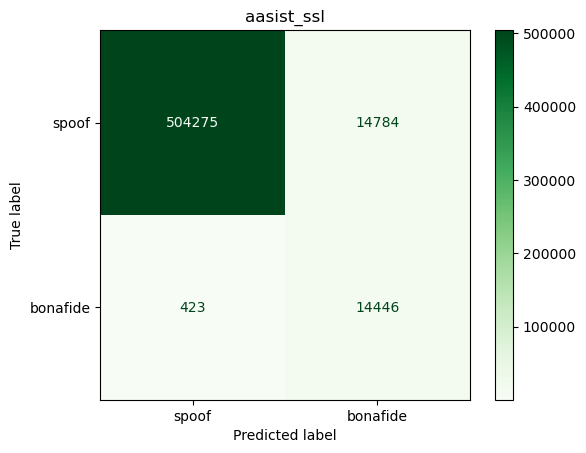

In [45]:

pred_df = pd.read_csv("scores/df2021/aasist_ssl.txt", sep=" ", header=None)
pred_df.columns = ["utt","asdf", "score"]

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
# merge eval_df and pred_df on utt
res_df = pd.merge(DF_df, pred_df, on='utt')

# filter res_df as subset = ['eval', 'hidden']
res_df = res_df[res_df['subset'] == 'eval']

# filter res_df which has vocoder neural_vocoder_autoregressive
# res_df = res_df[(res_df['vocoder'] == 'neural_vocoder_autoregressive') | (res_df['vocoder'] == 'bonafide')]

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("aasist_ssl")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

4.811042308807373 -3.820472955703736


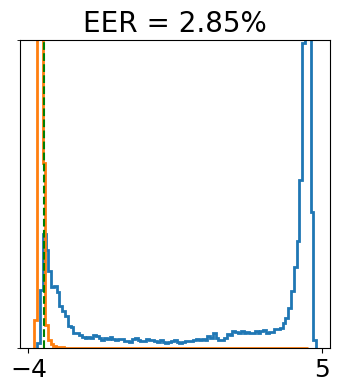

In [46]:
import matplotlib.pyplot as plt
import numpy as np

max_score = max(res_df['score'])
min_score = min(res_df['score'])
print(max_score, min_score)

plt.figure(figsize=(4, 4))
bona = res_df[(res_df['label'] == 'bonafide')]['score']
spoof = res_df[(res_df['label'] == 'spoof')]['score']

# Plotting the distributions as line chart histograms
plt.hist(bona, bins=100, density=True, cumulative=False, histtype='step', linewidth=2, label='Bonafide')
plt.hist(spoof, bins=100, density=True, cumulative=False, histtype='step', linewidth=2, label='Spoofing')


# Adding labels and title
# plt.xlabel('Scores', fontsize=20)
# plt.ylabel('score probability density plot')
plt.title('EER = {:.2f}%'.format(eer*100), fontsize=20)


# yaxis logit scale
plt.yscale('symlog')


# Adding a legend
# plt.legend(loc='lower right')
# Adding vertical lines
plt.axvline(x=threshold, color='g', linestyle='--', linewidth=1.5)

# Set the x-axis tick positions and labels
plt.xticks([int(min_score)-1,int(max_score)+1], fontsize=18)
plt.yticks([])
plt.ylim(0,1)
# save fig
# plt.savefig("figs/aasist-df.pdf", dpi=600)
# Displaying the plot
plt.show()


### Vocosig

EER: 2.1857%, threshold: -2.6224


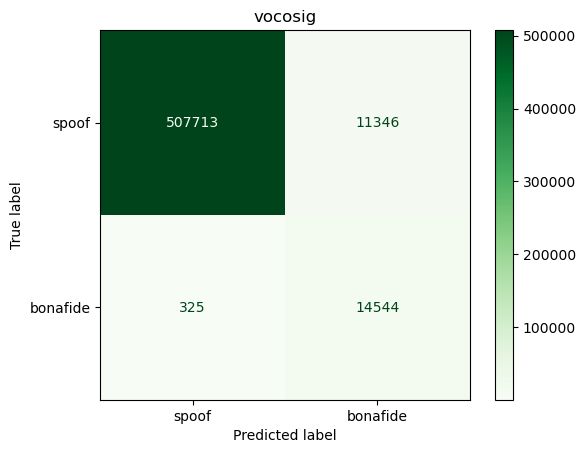

In [47]:

pred_df = pd.read_csv("scores/df2021/vocosig.txt", sep=" ", header=None)
pred_df.columns = ["utt","asdf", "score"]

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
# merge eval_df and pred_df on utt
res_df = pd.merge(DF_df, pred_df, on='utt')

# filter res_df as subset = ['eval', 'hidden']
res_df = res_df[res_df['subset'] == 'eval']

# filter res_df which has vocoder neural_vocoder_autoregressive
# res_df = res_df[(res_df['vocoder'] == 'neural_vocoder_autoregressive') | (res_df['vocoder'] == 'bonafide')]

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("vocosig")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

-0.0007894498412497 -7.514149665832519


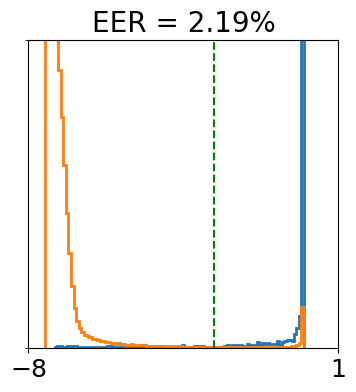

In [48]:
import matplotlib.pyplot as plt
import numpy as np

max_score = max(res_df['score'])
min_score = min(res_df['score'])
print(max_score, min_score)

plt.figure(figsize=(4, 4))
bona = res_df[(res_df['label'] == 'bonafide')]['score']
spoof = res_df[(res_df['label'] == 'spoof')]['score']

# Plotting the distributions as line chart histograms
plt.hist(bona, bins=100, density=True, cumulative=False, histtype='step', linewidth=2, label='Bonafide')
plt.hist(spoof, bins=100, density=True, cumulative=False, histtype='step', linewidth=2, label='Spoofing')


# Adding labels and title
# plt.xlabel('Scores', fontsize=20)
# plt.ylabel('score probability density plot')
plt.title('EER = {:.2f}%'.format(eer*100), fontsize=20)


# yaxis logit scale
plt.yscale('symlog')


# Adding a legend
# plt.legend(loc='lower right')
# Adding vertical lines
plt.axvline(x=threshold, color='g', linestyle='--', linewidth=1.5)

# Set the x-axis tick positions and labels
plt.xticks([int(min_score)-1,int(max_score)+1], fontsize=18)
plt.yticks([])
plt.ylim(0,1)
# save fig
# plt.savefig("figs/aasist-df.pdf", dpi=600)
# Displaying the plot
plt.show()


### conf-1 Not Norm

EER: 2.8464%, threshold: -3.5327


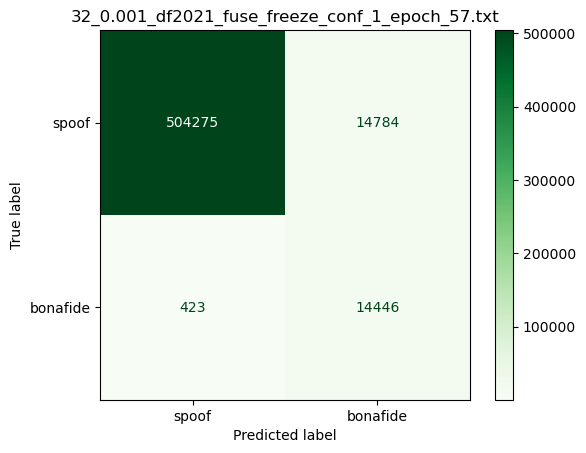

In [61]:

pred_df = pd.read_csv("docs/32_0.001_df2021_fuse_freeze_conf_1_epoch_57.txt", sep=" ", header=None)
pred_df.columns = ["utt", "score"]

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
# merge eval_df and pred_df on utt
res_df = pd.merge(DF_df, pred_df, on='utt')

# filter res_df as subset = ['eval', 'hidden']
res_df = res_df[res_df['subset'] == 'eval']

# filter res_df which has vocoder neural_vocoder_autoregressive
# res_df = res_df[(res_df['vocoder'] == 'neural_vocoder_autoregressive') | (res_df['vocoder'] == 'bonafide')]

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("32_0.001_df2021_fuse_freeze_conf_1_epoch_57.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

4.811042308807373 -3.820472955703736


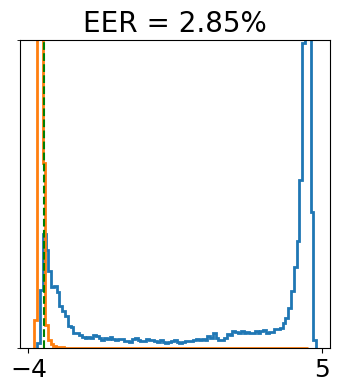

In [62]:
import matplotlib.pyplot as plt
import numpy as np

max_score = max(res_df['score'])
min_score = min(res_df['score'])
print(max_score, min_score)

plt.figure(figsize=(4, 4))
bona = res_df[(res_df['label'] == 'bonafide')]['score']
spoof = res_df[(res_df['label'] == 'spoof')]['score']

# Plotting the distributions as line chart histograms
plt.hist(bona, bins=100, density=True, cumulative=False, histtype='step', linewidth=2, label='Bonafide')
plt.hist(spoof, bins=100, density=True, cumulative=False, histtype='step', linewidth=2, label='Spoofing')


# Adding labels and title
# plt.xlabel('Scores', fontsize=20)
# plt.ylabel('score probability density plot')
plt.title('EER = {:.2f}%'.format(eer*100), fontsize=20)


# yaxis logit scale
plt.yscale('symlog')


# Adding a legend
# plt.legend(loc='lower right')
# Adding vertical lines
plt.axvline(x=threshold, color='g', linestyle='--', linewidth=1.5)

# Set the x-axis tick positions and labels
plt.xticks([int(min_score)-1,int(max_score)+1], fontsize=18)
plt.yticks([])
plt.ylim(0,1)
# save fig
# plt.savefig("figs/aasist-df.pdf", dpi=600)
# Displaying the plot
plt.show()


### conf-1 Norm

<bound method NDFrame.head of                  utt     score
0       DF_E_2000011 -3.655202
1       DF_E_2000013 -3.633837
2       DF_E_2000024 -3.661236
3       DF_E_2000026 -3.670653
4       DF_E_2000027 -3.640532
...              ...       ...
611824  DF_E_4999945 -3.639134
611825  DF_E_4999962 -3.614962
611826  DF_E_4999964 -3.615269
611827  DF_E_4999980 -3.598220
611828  DF_E_4999993 -3.668018

[611829 rows x 2 columns]>
EER: 2.8643%, threshold: -3.5349


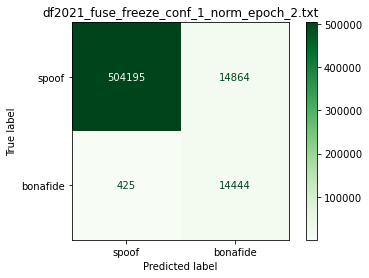

In [5]:

pred_df = pd.read_csv("docs/df2021_fuse_freeze_conf_1_norm_epoch_2.txt", sep=" ", header=None)
pred_df.columns = ["utt", "score"]

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
print(pred_df.head)
# merge eval_df and pred_df on utt
res_df = pd.merge(DF_df, pred_df, on='utt')

# filter res_df as subset = ['eval', 'hidden']
res_df = res_df[res_df['subset'] == 'eval']

# filter res_df which has vocoder neural_vocoder_autoregressive
# res_df = res_df[(res_df['vocoder'] == 'neural_vocoder_autoregressive') | (res_df['vocoder'] == 'bonafide')]

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("df2021_fuse_freeze_conf_1_norm_epoch_2.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

4.678706645965576 -4.102919101715088


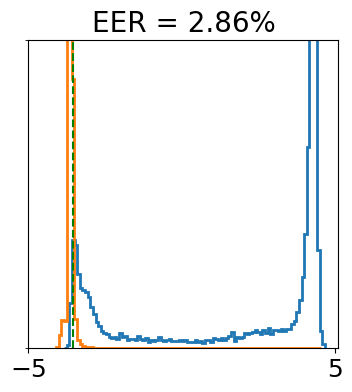

In [64]:
import matplotlib.pyplot as plt
import numpy as np

max_score = max(res_df['score'])
min_score = min(res_df['score'])
print(max_score, min_score)

plt.figure(figsize=(4, 4))
bona = res_df[(res_df['label'] == 'bonafide')]['score']
spoof = res_df[(res_df['label'] == 'spoof')]['score']

# Plotting the distributions as line chart histograms
plt.hist(bona, bins=100, density=True, cumulative=False, histtype='step', linewidth=2, label='Bonafide')
plt.hist(spoof, bins=100, density=True, cumulative=False, histtype='step', linewidth=2, label='Spoofing')


# Adding labels and title
# plt.xlabel('Scores', fontsize=20)
# plt.ylabel('score probability density plot')
plt.title('EER = {:.2f}%'.format(eer*100), fontsize=20)


# yaxis logit scale
plt.yscale('symlog')


# Adding a legend
# plt.legend(loc='lower right')
# Adding vertical lines
plt.axvline(x=threshold, color='g', linestyle='--', linewidth=1.5)

# Set the x-axis tick positions and labels
plt.xticks([int(min_score)-1,int(max_score)+1], fontsize=18)
plt.yticks([])
plt.ylim(0,1)
# save fig
# plt.savefig("figs/aasist-df.pdf", dpi=600)
# Displaying the plot
plt.show()


### df2021_fuse_freeze_conf_1_norm_2_epoch_21.txt

<bound method NDFrame.head of                  utt     score
0       DF_E_2000011  0.000217
1       DF_E_2000013  0.000238
2       DF_E_2000024  0.000220
3       DF_E_2000026  0.000221
4       DF_E_2000027  0.000224
...              ...       ...
611824  DF_E_4999945  0.000236
611825  DF_E_4999962  0.000245
611826  DF_E_4999964  0.000231
611827  DF_E_4999980  0.000303
611828  DF_E_4999993  0.000221

[611829 rows x 2 columns]>
EER: 2.0714%, threshold: 0.0003


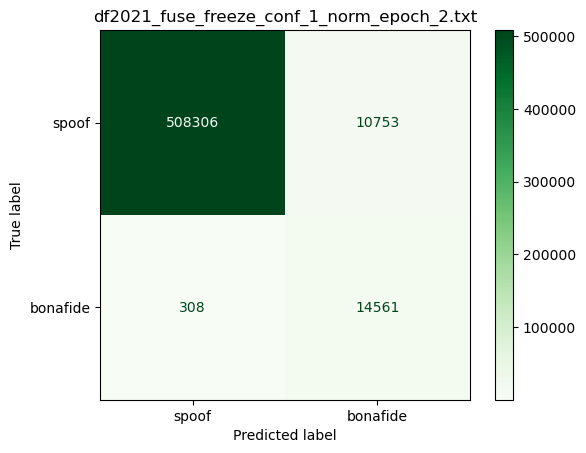

In [3]:

pred_df = pd.read_csv("docs/df2021_fuse_freeze_conf_1_norm_2_epoch_21.txt", sep=" ", header=None)
pred_df.columns = ["utt", "score"]

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
print(pred_df.head)
# merge eval_df and pred_df on utt
res_df = pd.merge(DF_df, pred_df, on='utt')

# filter res_df as subset = ['eval', 'hidden']
res_df = res_df[res_df['subset'] == 'eval']

# filter res_df which has vocoder neural_vocoder_autoregressive
# res_df = res_df[(res_df['vocoder'] == 'neural_vocoder_autoregressive') | (res_df['vocoder'] == 'bonafide')]

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("df2021_fuse_freeze_conf_1_norm_epoch_2.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

0.9999855756759644 0.0001800727914087


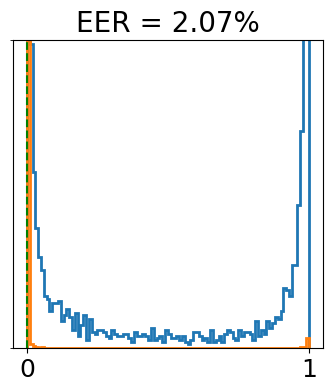

In [5]:
import matplotlib.pyplot as plt
import numpy as np

max_score = max(res_df['score'])
min_score = min(res_df['score'])
print(max_score, min_score)

plt.figure(figsize=(4, 4))
bona = res_df[(res_df['label'] == 'bonafide')]['score']
spoof = res_df[(res_df['label'] == 'spoof')]['score']

# Plotting the distributions as line chart histograms
plt.hist(bona, bins=100, density=True, cumulative=False, histtype='step', linewidth=2, label='Bonafide')
plt.hist(spoof, bins=100, density=True, cumulative=False, histtype='step', linewidth=2, label='Spoofing')


# Adding labels and title
# plt.xlabel('Scores', fontsize=20)
# plt.ylabel('score probability density plot')
plt.title('EER = {:.2f}%'.format(eer*100), fontsize=20)


# yaxis logit scale
plt.yscale('symlog')


# Adding a legend
# plt.legend(loc='lower right')
# Adding vertical lines
plt.axvline(x=threshold, color='g', linestyle='--', linewidth=1.5)

# Set the x-axis tick positions and labels
plt.xticks([0,1], fontsize=18)
plt.yticks([])
plt.ylim(0,1)
# save fig
# plt.savefig("figs/aasist-df.pdf", dpi=600)
# Displaying the plot
plt.show()


### Average fuse

In [6]:
# load df score of vocosig and aasist_ssl
score_vocosig_df = pd.read_csv("scores/df2021/vocosig.txt", sep=" ", header=None)
score_aasistssl_df = pd.read_csv("scores/df2021/aasist_ssl.txt", sep=" ", header=None)
score_vocosig_df.columns = ["utt","spoof","bona"]
score_aasistssl_df.columns = ["utt","spoof","bona"]

# normalize bona score for vocosig and aasist_ssl
score_vocosig_df['score'] = score_vocosig_df['bona'].apply(lambda x: (x-min(score_vocosig_df['bona']))/(max(score_vocosig_df['bona'])-min(score_vocosig_df['bona'])))
score_aasistssl_df['score'] = score_aasistssl_df['bona'].apply(lambda x: (x-min(score_aasistssl_df['bona']))/(max(score_aasistssl_df['bona'])-min(score_aasistssl_df['bona'])))

# merge vocosig and aasist_ssl
score_df = pd.merge(score_vocosig_df, score_aasistssl_df, on='utt')

# average score of vocosig and aasist_ssl
score_df['score'] = (score_df['score_x'] + score_df['score_y'])/2

# merge score_df and DF_df
res_df = pd.merge(DF_df, score_df, on='utt')

print(res_df.head)

<bound method NDFrame.head of Empty DataFrame
Columns: [sid, utt, codec, src, attack, label, trim, subset, vocoder, b, c, d, e, spoof_x, bona_x, score_x, spoof_y, bona_y, score_y, score]
Index: []>


In [22]:

score_df['utt'] = score_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
print(score_df.head)
res_df = pd.merge(DF_df, score_df, on='utt')

print(res_df.head)

<bound method NDFrame.head of                  utt   spoof_x    bona_x   score_x   spoof_y    bona_y  \
0       DF_E_2000011 -0.003996 -5.524437  0.264823  4.778521 -3.655193   
1       DF_E_2000013 -0.000638 -7.357205  0.020889  4.707773 -3.633462   
2       DF_E_2000024 -0.000837 -7.086616  0.056903  4.759364 -3.661224   
3       DF_E_2000026 -0.000669 -7.310718  0.027076  4.747497 -3.670639   
4       DF_E_2000027 -0.001293 -6.651572  0.114806  4.763486 -3.640492   
...              ...       ...       ...       ...       ...       ...   
611824  DF_E_4999945 -0.000655 -7.331472  0.024314  4.711147 -3.639119   
611825  DF_E_4999962 -0.000834 -7.089175  0.056563  4.697883 -3.614942   
611826  DF_E_4999964 -0.001764 -6.341135  0.156124  4.756473 -3.615253   
611827  DF_E_4999980 -0.000904 -7.008681  0.067276  4.502505 -3.598193   
611828  DF_E_4999993 -0.000589 -7.437008  0.010267  4.749809 -3.667919   

         score_y     score  
0       0.019131  0.141977  
1       0.021646  0.021

In [16]:
res_df.to_csv("docs/df2021_average_fuse.txt", sep=" ", index=False)

EER: 1.9570%, threshold: 0.3854


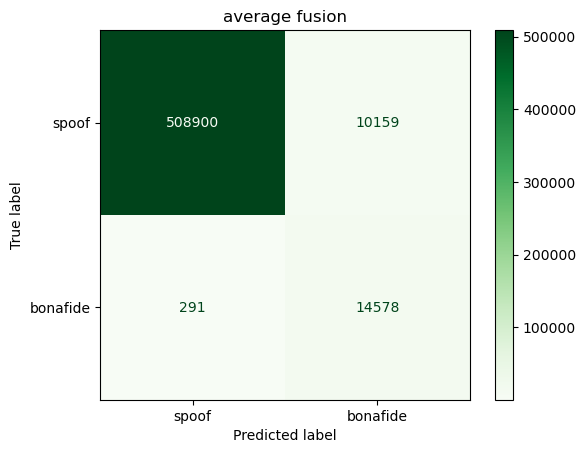

In [23]:
# filter res_df as subset = ['eval', 'hidden']
res_df = res_df[res_df['subset'] == 'eval']

# filter res_df which has vocoder neural_vocoder_autoregressive
# res_df = res_df[(res_df['vocoder'] == 'neural_vocoder_autoregressive') | (res_df['vocoder'] == 'bonafide')]

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("average fusion")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

0.9995308394213585 0.004301397378177654


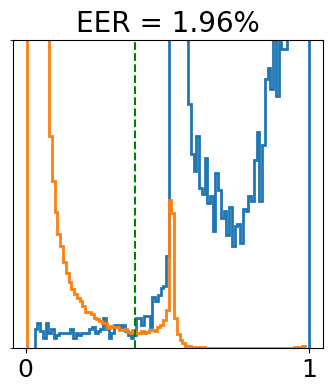

In [24]:
import matplotlib.pyplot as plt
import numpy as np

max_score = max(res_df['score'])
min_score = min(res_df['score'])
print(max_score, min_score)

plt.figure(figsize=(4, 4))
bona = res_df[(res_df['label'] == 'bonafide')]['score']
spoof = res_df[(res_df['label'] == 'spoof')]['score']

# Plotting the distributions as line chart histograms
plt.hist(bona, bins=100, density=True, cumulative=False, histtype='step', linewidth=2, label='Bonafide')
plt.hist(spoof, bins=100, density=True, cumulative=False, histtype='step', linewidth=2, label='Spoofing')


# Adding labels and title
# plt.xlabel('Scores', fontsize=20)
# plt.ylabel('score probability density plot')
plt.title('EER = {:.2f}%'.format(eer*100), fontsize=20)


# yaxis logit scale
plt.yscale('symlog')


# Adding a legend
# plt.legend(loc='lower right')
# Adding vertical lines
plt.axvline(x=threshold, color='g', linestyle='--', linewidth=1.5)

# Set the x-axis tick positions and labels
plt.xticks([0,1], fontsize=18)
plt.yticks([])
plt.ylim(0,1)
# save fig
# plt.savefig("figs/aasist-df.pdf", dpi=600)
# Displaying the plot
plt.show()


## LA2021

In [25]:
# load DF 2021 set
la2021_df = pd.read_csv("/datab/Dataset/ASVspoof/LA/ASVspoof2021_keys/LA/CM/trial_metadata.txt", sep=" ", header=None)
la2021_df.columns = ["sid", "utt", "codec", "logic", "attack", "label", "trim", "subset"]

la2021_df.head


<bound method NDFrame.head of             sid           utt codec   logic    attack     label         trim  \
0       LA_0009  LA_E_9332881  alaw  ita_tx       A07     spoof       notrim   
1       LA_0009  LA_E_6866159  alaw  ita_tx       A07     spoof       notrim   
2       LA_0009  LA_E_5464494  alaw  sin_tx       A07     spoof       notrim   
3       LA_0009  LA_E_4759417  alaw  sin_tx       A07     spoof       notrim   
4       LA_0009  LA_E_2667748  alaw  loc_tx       A07     spoof       notrim   
...         ...           ...   ...     ...       ...       ...          ...   
181561  LA_0021  LA_E_5789339   gsm  loc_tx  bonafide  bonafide  only_speech   
181562  LA_0021  LA_E_8256205  pstn  mad_tx  bonafide  bonafide  only_speech   
181563  LA_0021  LA_E_2369469  g722  loc_tx  bonafide  bonafide  only_speech   
181564  LA_0021  LA_E_8617705  opus  loc_tx  bonafide  bonafide  only_speech   
181565  LA_0021  LA_E_7310647  none       -  bonafide  bonafide  only_speech   

        s

### la2021_fuse_freeze_conf_2_epoch_11.txt

EER: 6.9452%, threshold: -3.4776


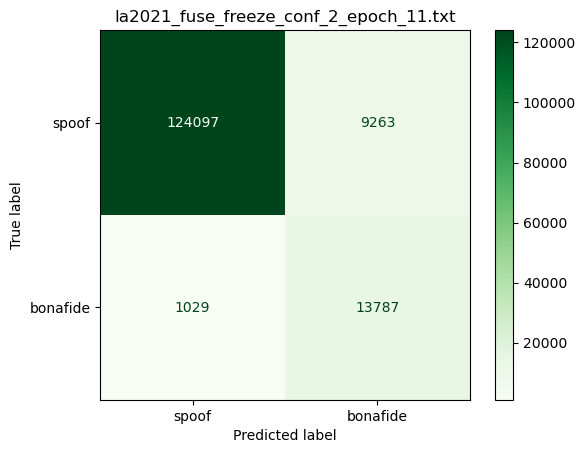

In [27]:
pred_df = pd.read_csv("docs/la2021_fuse_freeze_conf_2_epoch_11.txt", sep=" ", header=None)
pred_df.columns = ["utt","score"]
pred_df.utt = pred_df.utt.apply(lambda x: x.split('/')[-1].split('.')[0])
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(la2021_df, pred_df, on='utt')
# filter base on subset
res_df = res_df[res_df['subset'] == 'eval']
# print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("la2021_fuse_freeze_conf_2_epoch_11.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

4.419431209564209 -5.0365986824035645


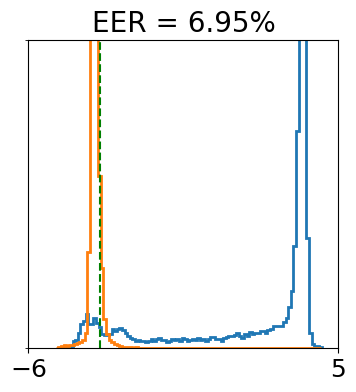

In [28]:
import matplotlib.pyplot as plt
import numpy as np

max_score = max(res_df['score'])
min_score = min(res_df['score'])
print(max_score, min_score)

plt.figure(figsize=(4, 4))
bona = res_df[(res_df['label'] == 'bonafide')]['score']
spoof = res_df[(res_df['label'] == 'spoof')]['score']

# Plotting the distributions as line chart histograms
plt.hist(bona, bins=100, density=True, cumulative=False, histtype='step', linewidth=2, label='Bonafide')
plt.hist(spoof, bins=100, density=True, cumulative=False, histtype='step', linewidth=2, label='Spoofing')


# Adding labels and title
# plt.xlabel('Scores', fontsize=20)
# plt.ylabel('score probability density plot')
plt.title('EER = {:.2f}%'.format(eer*100), fontsize=20)


# yaxis logit scale
plt.yscale('symlog')


# Adding a legend
# plt.legend(loc='lower right')
# Adding vertical lines
plt.axvline(x=threshold, color='g', linestyle='--', linewidth=1.5)

# Set the x-axis tick positions and labels
plt.xticks([int(min_score)-1,int(max_score)+1], fontsize=18)
plt.yticks([])
plt.ylim(0,1)
# save fig
# plt.savefig("figs/aasist-df.pdf", dpi=600)
# Displaying the plot
plt.show()


## Supcon_nov22

In [2]:
supcon_nov22_df = pd.read_csv("DATA/supcon_cnsl_nov22/protocol.txt", sep=" ", header=None)
supcon_nov22_df.columns = ["utt", "subset", "category", "label"]
# supcon_nov22_df = supcon_nov22_df[supcon_nov22_df['subset'] == 'eval']
supcon_nov22_df.head

<bound method NDFrame.head of                                              utt subset category     label
0                      bonafide/LA_T_3424442.wav  train        -  bonafide
1               vocoded/hifigan_LA_T_3424442.wav  train        -     spoof
2              vocoded/waveglow_LA_T_3424442.wav  train        -     spoof
3      vocoded/hn-sinc-nsf-hifi_LA_T_3424442.wav  train        -     spoof
4                      bonafide/LA_T_3976536.wav  train        -  bonafide
...                                          ...    ...      ...       ...
31547                     spoof/LA_T_6758106.wav  train        -     spoof
31548                spoof/03FLSH0026_000190.wav  train        -     spoof
31549                spoof/03MAPK0028_000058.wav  train        -     spoof
31550                     spoof/LA_T_9861717.wav    dev        -     spoof
31551                     spoof/LA_T_4019514.wav  train        -     spoof

[31552 rows x 4 columns]>

### average fuse:

In [16]:
# load vocosig score
vocosig_df = pd.read_csv("scores/supcon_nov22/vocosig.txt", sep=" ", header=None)
vocosig_df.columns = ["utt", "spoof", "score"]

# load aasist_ssl score
aasist_ssl_df = pd.read_csv("scores/supcon_nov22/aasist_ssl.txt", sep=" ", header=None)
aasist_ssl_df.columns = ["utt", "spoof", "score"]

# load btse score
btse_df = pd.read_csv("scores/supcon_nov22/btse_wav2vec.txt", sep=" ", header=None)
btse_df.columns = ["utt", "spoof", "score"]



<bound method NDFrame.head of                                              utt   spoof_x   spoof_y  \
0                      bonafide/LA_T_3424442.wav -7.087940 -5.989775   
1               vocoded/hifigan_LA_T_3424442.wav -0.000679  4.141654   
2              vocoded/waveglow_LA_T_3424442.wav -0.000671  4.723061   
3      vocoded/hn-sinc-nsf-hifi_LA_T_3424442.wav -0.000664  4.417363   
4                      bonafide/LA_T_3976536.wav -7.122696 -6.055445   
...                                          ...       ...       ...   
31547                     spoof/LA_T_6758106.wav -0.001812  4.690410   
31548                spoof/03FLSH0026_000190.wav -0.000963  4.751920   
31549                spoof/03MAPK0028_000058.wav -0.262836  4.750031   
31550                     spoof/LA_T_9861717.wav -0.000704  4.752419   
31551                     spoof/LA_T_4019514.wav -0.027610  4.720073   

        score_x      spoof    score_y  
0      2.245994 -10.204299  -0.000037  
1     -5.203559 -10.29544

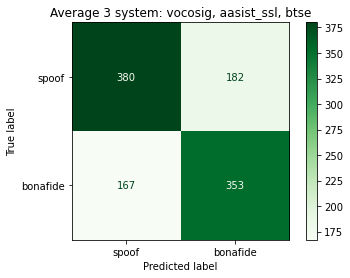

In [24]:
avg_df = pd.merge(vocosig_df, aasist_ssl_df, on='utt')
# print(avg_df.head)
avg_df['score'] = (avg_df['score_x'] + avg_df['score_y'])/2
avg_df.drop(['score_x', 'score_y'], axis=1, inplace=True)
avg_df = pd.merge(avg_df, btse_df, on='utt')
print(avg_df.head)
avg_df['score'] = (avg_df['score_x'] + avg_df['score_y'])/2
avg_df.drop(['score_x', 'score_y'], axis=1, inplace=True)
avg_df = pd.merge(avg_df, supcon_nov22_df, on='utt')
avg_df = avg_df[avg_df['subset'] == 'eval']

# compute EER
spoof_scores = avg_df[avg_df['label'] == 'spoof']['score']
bonafide_scores = avg_df[avg_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)

print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
avg_df['pred'] = avg_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(avg_df["label"], avg_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("Average 3 system: vocosig, aasist_ssl, btse")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### supcon_nov22_fuse_joint_conf_2_3_noisetype_supcon_nov22_epoch_57.txt

<bound method NDFrame.head of                                               utt subset category     label  \
0                                eval/Chick_2.wav   eval    Music     spoof   
1                eval/2021_10_05_AI_WEATHER_8.wav   eval        -     spoof   
2                 eval/2021_04_15_AI_ANCHOR_2.wav   eval    Music     spoof   
3     eval/FreddieMercury_AIcover_oortCloud_4.wav   eval    Music     spoof   
4     eval/FreddieMercury_AIcover_oortCloud_9.wav   eval    Music     spoof   
...                                           ...    ...      ...       ...   
1077                    eval/01MPJH0028_00557.wav   eval        -  bonafide   
1078                    eval/05MKH00040_07703.wav   eval        -  bonafide   
1079                    eval/07FYSH0052_10363.wav   eval        -  bonafide   
1080                    eval/07FSKO0049_09848.wav   eval        -  bonafide   
1081                    eval/09MJHS0042_14619.wav   eval        -  bonafide   

         score  
0   

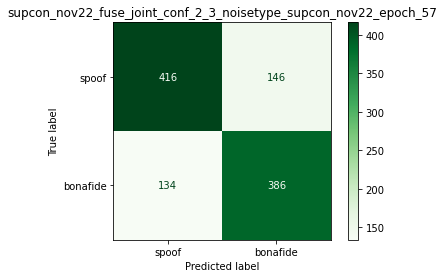

In [9]:
pred_df = pd.read_csv("docs/supcon_nov22_fuse_joint_conf_2_3_noisetype_supcon_nov22_epoch_57.txt", sep=" ", header=None)
pred_df.columns = ["utt","score"]
# pred_df.utt = pred_df.utt.apply(lambda x: x.split('/')[-1].split('.')[0])
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(supcon_nov22_df, pred_df, on='utt')
# filter base on subset
res_df = res_df[res_df['subset'] == 'eval']
print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("supcon_nov22_fuse_joint_conf_2_3_noisetype_supcon_nov22_epoch_57")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### vocosig conf-3-la19

<bound method NDFrame.head of                                                utt subset category     label  \
27600                             eval/Chick_2.wav   eval    Music     spoof   
27601             eval/2021_10_05_AI_WEATHER_8.wav   eval        -     spoof   
27602              eval/2021_04_15_AI_ANCHOR_2.wav   eval    Music     spoof   
27603  eval/FreddieMercury_AIcover_oortCloud_4.wav   eval    Music     spoof   
27604  eval/FreddieMercury_AIcover_oortCloud_9.wav   eval    Music     spoof   
...                                            ...    ...      ...       ...   
28677                    eval/01MPJH0028_00557.wav   eval        -  bonafide   
28678                    eval/05MKH00040_07703.wav   eval        -  bonafide   
28679                    eval/07FYSH0052_10363.wav   eval        -  bonafide   
28680                    eval/07FSKO0049_09848.wav   eval        -  bonafide   
28681                    eval/09MJHS0042_14619.wav   eval        -  bonafide   

         

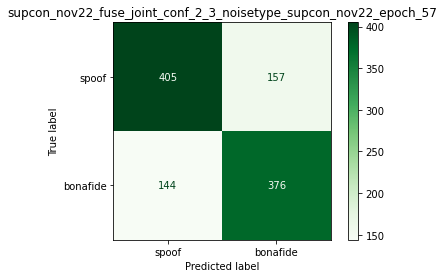

In [11]:
pred_df = pd.read_csv("scores/supcon_nov22/vocosig.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
# pred_df.utt = pred_df.utt.apply(lambda x: x.split('/')[-1].split('.')[0])
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(supcon_nov22_df, pred_df, on='utt')
# filter base on subset
res_df = res_df[res_df['subset'] == 'eval']
print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("supcon_nov22_fuse_joint_conf_2_3_noisetype_supcon_nov22_epoch_57")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### aasist_ssl best df

<bound method NDFrame.head of                                                utt subset category     label  \
27600                             eval/Chick_2.wav   eval    Music     spoof   
27601             eval/2021_10_05_AI_WEATHER_8.wav   eval        -     spoof   
27602              eval/2021_04_15_AI_ANCHOR_2.wav   eval    Music     spoof   
27603  eval/FreddieMercury_AIcover_oortCloud_4.wav   eval    Music     spoof   
27604  eval/FreddieMercury_AIcover_oortCloud_9.wav   eval    Music     spoof   
...                                            ...    ...      ...       ...   
28677                    eval/01MPJH0028_00557.wav   eval        -  bonafide   
28678                    eval/05MKH00040_07703.wav   eval        -  bonafide   
28679                    eval/07FYSH0052_10363.wav   eval        -  bonafide   
28680                    eval/07FSKO0049_09848.wav   eval        -  bonafide   
28681                    eval/09MJHS0042_14619.wav   eval        -  bonafide   

         

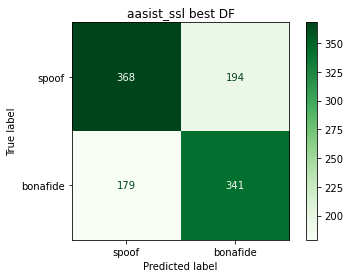

In [14]:
pred_df = pd.read_csv("scores/supcon_nov22/aasist_ssl.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
# pred_df.utt = pred_df.utt.apply(lambda x: x.split('/')[-1].split('.')[0])
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(supcon_nov22_df, pred_df, on='utt')
# filter base on subset
res_df = res_df[res_df['subset'] == 'eval']
print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("aasist_ssl best DF")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### BTS_E wav2vec

<bound method NDFrame.head of                                                utt subset category     label  \
27600                             eval/Chick_2.wav   eval    Music     spoof   
27601             eval/2021_10_05_AI_WEATHER_8.wav   eval        -     spoof   
27602              eval/2021_04_15_AI_ANCHOR_2.wav   eval    Music     spoof   
27603  eval/FreddieMercury_AIcover_oortCloud_4.wav   eval    Music     spoof   
27604  eval/FreddieMercury_AIcover_oortCloud_9.wav   eval    Music     spoof   
...                                            ...    ...      ...       ...   
28677                    eval/01MPJH0028_00557.wav   eval        -  bonafide   
28678                    eval/05MKH00040_07703.wav   eval        -  bonafide   
28679                    eval/07FYSH0052_10363.wav   eval        -  bonafide   
28680                    eval/07FSKO0049_09848.wav   eval        -  bonafide   
28681                    eval/09MJHS0042_14619.wav   eval        -  bonafide   

         

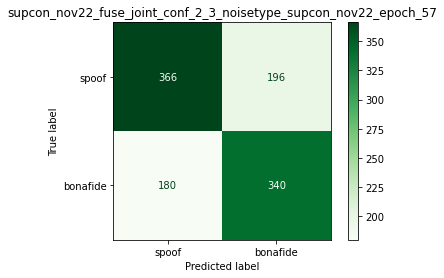

In [13]:
pred_df = pd.read_csv("scores/supcon_nov22/btse_wav2vec.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
# pred_df.utt = pred_df.utt.apply(lambda x: x.split('/')[-1].split('.')[0])
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(supcon_nov22_df, pred_df, on='utt')
# filter base on subset
res_df = res_df[res_df['subset'] == 'eval']
print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("supcon_nov22_fuse_joint_conf_2_3_noisetype_supcon_nov22_epoch_57")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### vocosig supcon_nov22

<bound method NDFrame.head of                                                utt subset category     label  \
27600                             eval/Chick_2.wav   eval    Music     spoof   
27601             eval/2021_10_05_AI_WEATHER_8.wav   eval        -     spoof   
27602              eval/2021_04_15_AI_ANCHOR_2.wav   eval    Music     spoof   
27603  eval/FreddieMercury_AIcover_oortCloud_4.wav   eval    Music     spoof   
27604  eval/FreddieMercury_AIcover_oortCloud_9.wav   eval    Music     spoof   
...                                            ...    ...      ...       ...   
28677                    eval/01MPJH0028_00557.wav   eval        -  bonafide   
28678                    eval/05MKH00040_07703.wav   eval        -  bonafide   
28679                    eval/07FYSH0052_10363.wav   eval        -  bonafide   
28680                    eval/07FSKO0049_09848.wav   eval        -  bonafide   
28681                    eval/09MJHS0042_14619.wav   eval        -  bonafide   

         

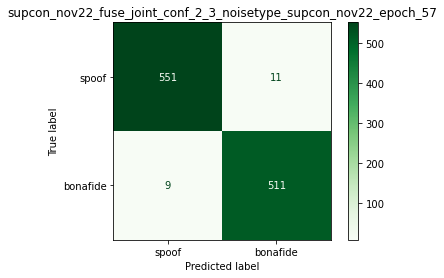

In [15]:
pred_df = pd.read_csv("/datab/phucdt/feats/vocosig_conf5_nov22/supcon_nov22/scores.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
# pred_df.utt = pred_df.utt.apply(lambda x: x.split('/')[-1].split('.')[0])
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(supcon_nov22_df, pred_df, on='utt')
# filter base on subset
res_df = res_df[res_df['subset'] == 'eval']
print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("supcon_nov22_fuse_joint_conf_2_3_noisetype_supcon_nov22_epoch_57")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### aasist_ssl supcon nov22

<bound method NDFrame.head of                                                utt subset category     label  \
27600                             eval/Chick_2.wav   eval    Music     spoof   
27601             eval/2021_10_05_AI_WEATHER_8.wav   eval        -     spoof   
27602              eval/2021_04_15_AI_ANCHOR_2.wav   eval    Music     spoof   
27603  eval/FreddieMercury_AIcover_oortCloud_4.wav   eval    Music     spoof   
27604  eval/FreddieMercury_AIcover_oortCloud_9.wav   eval    Music     spoof   
...                                            ...    ...      ...       ...   
28677                    eval/01MPJH0028_00557.wav   eval        -  bonafide   
28678                    eval/05MKH00040_07703.wav   eval        -  bonafide   
28679                    eval/07FYSH0052_10363.wav   eval        -  bonafide   
28680                    eval/07FSKO0049_09848.wav   eval        -  bonafide   
28681                    eval/09MJHS0042_14619.wav   eval        -  bonafide   

         

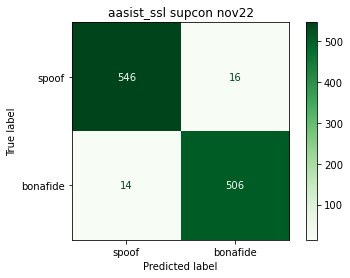

In [4]:
pred_df = pd.read_csv("/datab/phucdt/feats/aasistssl_nov22/supcon_nov22/scores.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
# pred_df.utt = pred_df.utt.apply(lambda x: x.split('/')[-1].split('.')[0])
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(supcon_nov22_df, pred_df, on='utt')
# filter base on subset
res_df = res_df[res_df['subset'] == 'eval']
print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("aasist_ssl supcon nov22")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### BTS-E supcon nov22

<bound method NDFrame.head of                                                utt subset category     label  \
27600                             eval/Chick_2.wav   eval    Music     spoof   
27601             eval/2021_10_05_AI_WEATHER_8.wav   eval        -     spoof   
27602              eval/2021_04_15_AI_ANCHOR_2.wav   eval    Music     spoof   
27603  eval/FreddieMercury_AIcover_oortCloud_4.wav   eval    Music     spoof   
27604  eval/FreddieMercury_AIcover_oortCloud_9.wav   eval    Music     spoof   
...                                            ...    ...      ...       ...   
28677                    eval/01MPJH0028_00557.wav   eval        -  bonafide   
28678                    eval/05MKH00040_07703.wav   eval        -  bonafide   
28679                    eval/07FYSH0052_10363.wav   eval        -  bonafide   
28680                    eval/07FSKO0049_09848.wav   eval        -  bonafide   
28681                    eval/09MJHS0042_14619.wav   eval        -  bonafide   

         

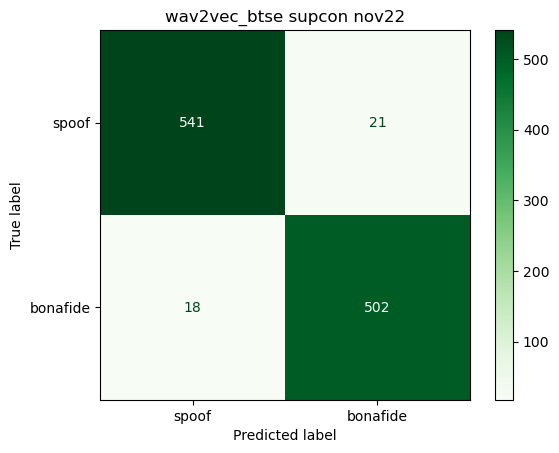

In [5]:
pred_df = pd.read_csv("/datab/phucdt/feats/wav2vec_btse_nov22/supcon_nov22/scores.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
# pred_df.utt = pred_df.utt.apply(lambda x: x.split('/')[-1].split('.')[0])
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(supcon_nov22_df, pred_df, on='utt')
# filter base on subset
res_df = res_df[res_df['subset'] == 'eval']
print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("wav2vec_btse supcon nov22")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### supcon_nov22_1e-06_supcon_nov22_fuse_joint_conf_2_noisetype_epoch_14.txt

<bound method NDFrame.head of                                               utt subset category     label  \
0                                eval/Chick_2.wav   eval    Music     spoof   
1                eval/2021_10_05_AI_WEATHER_8.wav   eval        -     spoof   
2                 eval/2021_04_15_AI_ANCHOR_2.wav   eval    Music     spoof   
3     eval/FreddieMercury_AIcover_oortCloud_4.wav   eval    Music     spoof   
4     eval/FreddieMercury_AIcover_oortCloud_9.wav   eval    Music     spoof   
...                                           ...    ...      ...       ...   
1077                    eval/01MPJH0028_00557.wav   eval        -  bonafide   
1078                    eval/05MKH00040_07703.wav   eval        -  bonafide   
1079                    eval/07FYSH0052_10363.wav   eval        -  bonafide   
1080                    eval/07FSKO0049_09848.wav   eval        -  bonafide   
1081                    eval/09MJHS0042_14619.wav   eval        -  bonafide   

         score  
0   

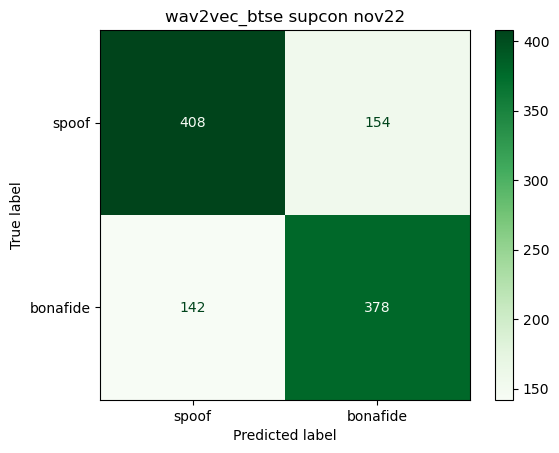

In [6]:
pred_df = pd.read_csv("docs/supcon_nov22_1e-06_supcon_nov22_fuse_joint_conf_2_noisetype_epoch_14.txt", sep=" ", header=None)
pred_df.columns = ["utt","score"]
# pred_df.utt = pred_df.utt.apply(lambda x: x.split('/')[-1].split('.')[0])
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(supcon_nov22_df, pred_df, on='utt')
# filter base on subset
res_df = res_df[res_df['subset'] == 'eval']
print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("wav2vec_btse supcon nov22")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()